In [376]:
import numpy as np 
import pandas as pd
import pickle
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_theme()

In [377]:
def sigmoid(x):
    return 1.0/(1 + np.exp(-x))

In [378]:
param_name = "Theta_2"

with open(f'/home/chri6578/Documents/CES/params/{param_name}.pickle', 'rb') as file:
    Theta = pickle.load(file)
    
n = Theta['n']
Lambda = Theta['Lambda']
Eta = Theta['Eta']
Alpha = Theta['Alpha']
Beta = Theta['Beta']
Gamma = Theta['Gamma']
T = 1e4

In [379]:
# step 2
PHI = {}

for i in range(n):
    PHI[i] = []
    t = 0
    t_prev = 0
    while t_prev < T:
        t = np.random.exponential(Lambda[i])[0]
        PHI[i].append(t + t_prev)
        t_prev = t + t_prev

In [380]:
# step 3
tuple_list = [(i, t) for i in range(n) for t in PHI[i]]
T_list = sorted(tuple_list, key=lambda x: x[1])

In [381]:
# steps 4-11

E_all = {}
for i in range(n):
    E_all[i] = []
t_last = np.zeros((n,))

for (e,t) in T_list:
    # update x_i^t
    s = np.sum( Gamma[e]*np.power(t- t_last, Alpha[e]-1)*np.exp(-(t-t_last)*Beta[e])*(t_last != 0) ) + Eta[e]
    p = sigmoid(s)
    # print(s, p)
    trial = np.random.binomial(1,p)
    if trial:
        E_all[e].append(t)
        t_last[e] = t

In [382]:
# save PHI, and E_all

# load Theta, PHI, and E_all

In [383]:
# Estimating Probability of Causation 

tau_bar = 500

Pn = np.zeros((n,n))
Ps = np.zeros((n,n))
Pns = np.zeros((n,n))

for i in range(n):
    Pa_i = [k for k in  range(n) if Alpha[i][k] > 0 ]
    print(Pa_i)
    for j in range(n):
        gPn = [] 
        gPs = [] 
        n_yz_ = 0
        n_y_z = 0
        for t in PHI[i]:
            # search for j in (t -tau_bar, t)
            Lij = [t_ for t_ in E_all[j] if t - tau_bar < t_ <= t]
            if len(Lij) > 0:
                if t in E_all[i]:
                    # (y_i, z_j)
                    t_last = np.zeros((n,))
                    for k in Pa_i:
                        Lik = [t_ for t_ in E_all[k] if t - tau_bar < t_ <= t]
                        if len(Lik)>0:
                            t_last[k] = np.max(Lik)
                            
                    t_last[j] = 0 # imposing z_j' 
                    
                    #calculate probability of necessity                    
                    gPn.append(
                        1 -sigmoid( np.sum( Gamma[e]*np.power(t- t_last, Alpha[e]-1)*np.exp(-(t-t_last)*Beta[e])*(t_last != 0) ) 
                                + Eta[e] )[0]
                    )
                    
                
                else:
                    # (y_i', z_j)
                    n_y_z += 1
            
            else:
                if t not in E_all[i]:
                    # (y_i', z_j')
                    t_last = np.zeros((n,))
                    for k in Pa_i:
                        Lik = [t_ for t_ in E_all[k] if t - tau_bar < t_ <= t]
                        if len(Lik)>0:
                            t_last[k] = np.max(Lik)
                            
                    t_last[j] = np.random.uniform(t- tau_bar, t) # imposing z_j 
                    
                    #calculate probability of necessity                    
                    gPs.append(
                        sigmoid( np.sum( Gamma[e]*np.power(t- t_last, Alpha[e]-1)*np.exp(-(t-t_last)*Beta[e])*(t_last != 0) ) 
                                + Eta[e] )[0]
                    )
                
                else:
                    # (y_i, z_j')
                    n_yz_ += 1
                    
        # Calculate probabilities here
        
        gPn_mean = np.nanmean(gPn)
        gPs_mean = np.nanmean(gPs)
        
        
        Pn[i][j] = 0 if np.isnan(gPn_mean) else gPn_mean  
        Ps[i][j] = 0 if np.isnan(gPs_mean) else gPs_mean
        
        total = len(gPn) + len(gPs) + n_y_z + n_yz_
        Pns[i][j] = ( len(gPn)*Pn[i][j] + len(gPs)*Ps[i][j] )/ total

[0, 5, 6]
[1, 6]
[0, 2, 6]
[3, 4, 5]
[3, 4]
[4, 5, 9]
[2, 6]
[1, 2, 5, 6, 7]
[3, 5, 8, 9]
[3, 9]


/tmp/ipykernel_4102952/3324838345.py:33: RuntimeWarning: divide by zero encountered in power
  1 -sigmoid( np.sum( Gamma[e]*np.power(t- t_last, Alpha[e]-1)*np.exp(-(t-t_last)*Beta[e])*(t_last != 0) )
/tmp/ipykernel_4102952/3324838345.py:65: RuntimeWarning: Mean of empty slice
  gPn_mean = np.nanmean(gPn)
/tmp/ipykernel_4102952/3324838345.py:66: RuntimeWarning: Mean of empty slice
  gPs_mean = np.nanmean(gPs)
/tmp/ipykernel_4102952/3324838345.py:33: RuntimeWarning: invalid value encountered in multiply
  1 -sigmoid( np.sum( Gamma[e]*np.power(t- t_last, Alpha[e]-1)*np.exp(-(t-t_last)*Beta[e])*(t_last != 0) )


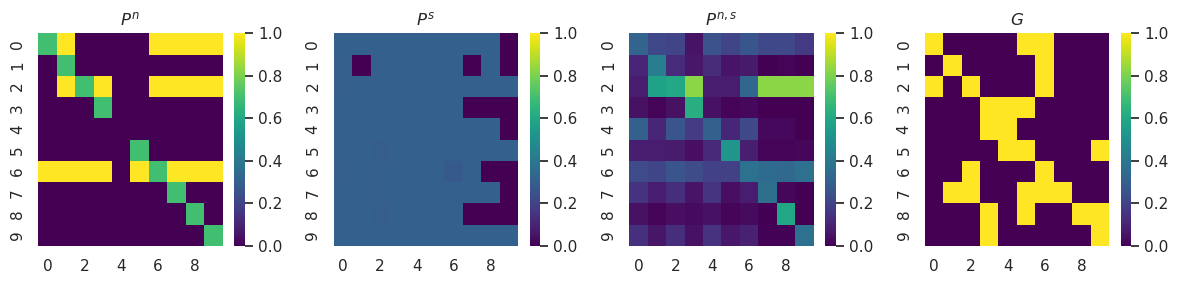

In [384]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

# Plot each heatmap
sns.heatmap(Pn, ax=axes[0], cmap="viridis", vmin=0, vmax=1)
axes[0].set_title("$ P^n $")

sns.heatmap(Ps, ax=axes[1], cmap="viridis", vmin=0, vmax=1)
axes[1].set_title("$ P^s $")

sns.heatmap(Pns, ax=axes[2], cmap="viridis", vmin=0, vmax=1)
axes[2].set_title("$ P^{n,s} $")

sns.heatmap(Alpha>0, ax=axes[3], cmap="viridis", vmin=0, vmax=1)
axes[3].set_title("$ G $")

# Adjust layout
plt.tight_layout()
plt.show()

In [385]:
G = np.double(Alpha > 0)

In [386]:
np.linalg.norm(G - Pn)/n, np.linalg.norm(G - Ps)/n, np.linalg.norm(G - Pns)/n

(0.5815925367238265, 0.46011522100038144, 0.47927786883874157)